In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from brokenaxes import brokenaxes

mpl.rcParams['font.size'] = 8

In [2]:
from scipy.signal import savgol_filter, find_peaks

In [3]:
def pseudo_voigt(x, mu, gamma_gaussian, gamma_lorentzian, amplitude, eta):
    """ 
    Voigt profile approximation by linear combination of
    Lorenzian and Gaussian distributinos.
    mu, A, A0, FWHM, eta
    """
    a_G = (2 / gamma_gaussian) * np.sqrt(np.log(2) / np.pi)
    b_G = (4 * np.log(2)) / (gamma_gaussian**2)
    gaussian_term = a_G * np.exp(-b_G * (x - mu)**2)
    
    lorentzian_term = (1 / np.pi) * ( (gamma_lorentzian / 2) / ( (x - mu)**2 + (gamma_lorentzian / 2)**2) ) 
    
    result = amplitude * (eta * gaussian_term + (1 - eta) * lorentzian_term)

    return result

In [4]:
x_values = np.linspace(0, 100, 1000)
y_values = (
            np.exp(-(x_values - 20)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 25)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 30)**2 / (2 * 2**2)) +
            np.exp(-(x_values - 50)**2 / (2 * 5**2)) +
            np.exp(-(x_values - 75)**2 / (2 * 3**2)) +
            np.exp(-(x_values - 80)**2 / (2 * 2**2)) + 
            np.random.normal(0, 0.001, x_values.size)
            )

In [5]:
df = pd.read_csv("~/data/dataset.csv")
wn = pd.read_csv("~/data/domain.csv").to_numpy().reshape(-1)
X = df.drop(columns=['HbA1c', 'years'])
X.columns = wn


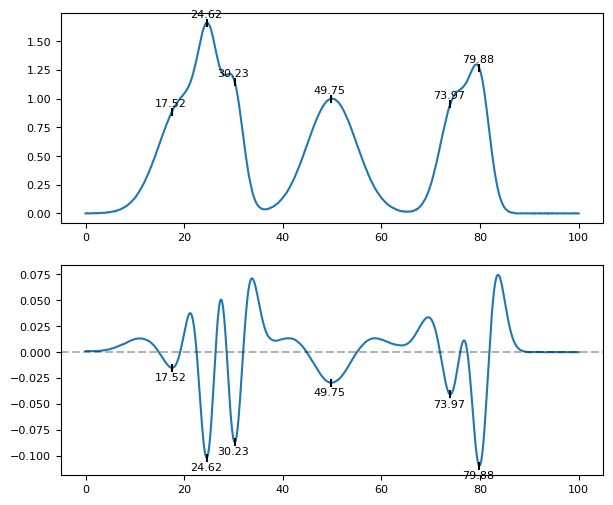

In [6]:
def peaks_second_deriv(x_values, 
                       y_values, 
                       window_length=10,
                       polyorder=2,
                       **kwargs):
    
    first_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=1)
    second_deriv = savgol_filter(y_values, window_length=window_length, polyorder=polyorder, deriv=2)
    second_deriv = second_deriv / np.linalg.norm(second_deriv)
    peaks = find_peaks(-second_deriv, **kwargs)[0]

    fig, axs = plt.subplots(2, 1, figsize=(7, 6))
    axs[0].plot(x_values, y_values)
    axs[0].scatter(x_values[peaks], y_values[peaks], color='k', marker='|', linewidth=1.5, zorder=5)

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[0].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, y_values[peak]), 
                        xytext=(peak_pos - 3.5, y_values[peak] + 0.1 * y_values.mean()),
                        fontsize=8
                        )

    axs[1].plot(x_values, second_deriv)
    axs[1].scatter(x_values[peaks], second_deriv[peaks], color='k', marker='|', linewidth=1.5, zorder=5)
    axs[1].axhline(y=0, linestyle="--", alpha=0.3, color='k')

    for peak in peaks:
        peak_pos = x_values[peak]
        axs[1].annotate(f'{peak_pos:.2f}', 
                        xy=(peak_pos, second_deriv[peak]), 
                        xytext=(peak_pos - 3.5, second_deriv[peak] - 0.6 * np.abs(second_deriv).mean()),
                        fontsize=8
                        )
        
    peak_results = pd.DataFrame({
        "Index": peaks,
        "Value": [int(x_values[peak]) for peak in peaks]
    })

    plt.show()

    return

peaks_second_deriv(x_values, 
                   y_values, 
                   window_length=50, 
                   height=0.001, 
                   prominence=0.0001, 
                   distance=20)

In [7]:
sample = X.mean()
sample = sample[(sample.index >= 1600) & (sample.index <= 1730)]

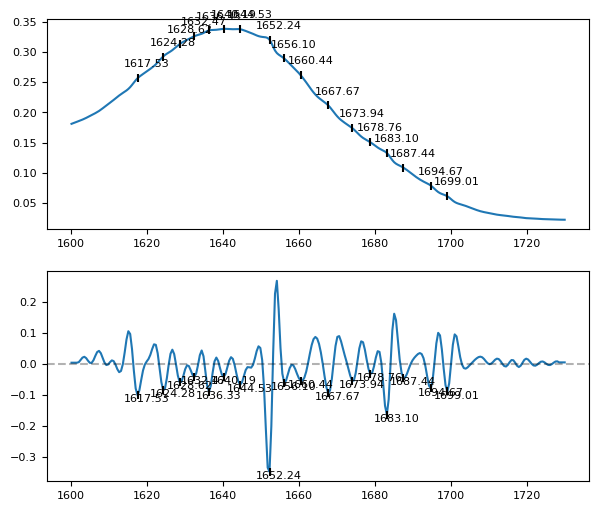

In [8]:
peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=7,
                   polyorder=2,
                   height=0.03, 
                   prominence=0.00001, 
                   distance=7)

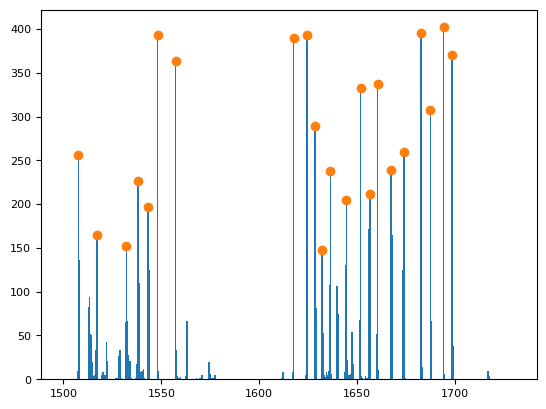

In [9]:
def find_peaks_matrix(domain,
                      absorbance,
                      window_length=10,
                      polyorder=2,
                      threshold=0.5,
                      **kwargs):
    
    n_samples, n_features = absorbance.shape
    
    X_deriv = absorbance.T.apply(lambda col: savgol_filter(col, 
                                                           window_length=window_length, 
                                                           polyorder=polyorder, 
                                                           deriv=2)).T
    X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)

    total_peaks = np.zeros(n_features)


    for index, row in X_deriv.iterrows():
        peaks = find_peaks(-row, **kwargs)[0]
        total_peaks[peaks] += 1


    peaks_counts, *_ = find_peaks(total_peaks, height=int(n_samples * threshold))
    plt.bar(domain, total_peaks)
    plt.scatter(domain[peaks_counts], total_peaks[peaks_counts])
    # plt.xlim([1600, 1730])
    plt.show()

    # print(peaks_counts.shape)
    # absorbance.T.plot(legend=False)
    # plt.scatter(domain[peaks_counts], absorbance.mean().to_numpy()[peaks_counts])

    return domain[peaks_counts]

X_amide1 = X.iloc[:, (X.columns >= 1500) & (X.columns <= 1730)]

peaks_amides = find_peaks_matrix(X_amide1.columns.to_numpy(), 
                  X_amide1, 
                   window_length=10, 
                   height=0.03, 
                   prominence=0.0001, 
                   distance=7,
                   threshold=0.3)

<Axes: >

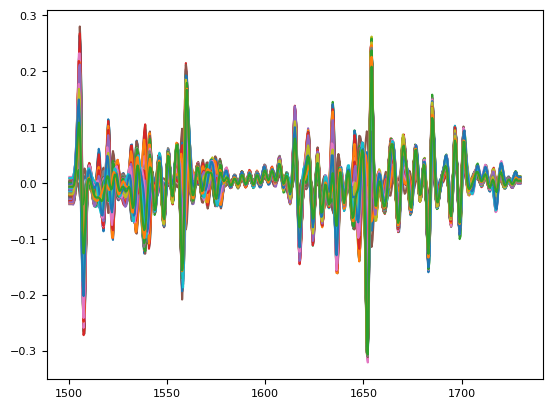

In [10]:
X_deriv = X_amide1.T.apply(lambda col: savgol_filter(col, window_length=7, polyorder=2, deriv=2)).T
X_deriv = X_deriv.apply(lambda row: row / np.linalg.norm(row), axis=1)
X_deriv.T.plot(legend=False)

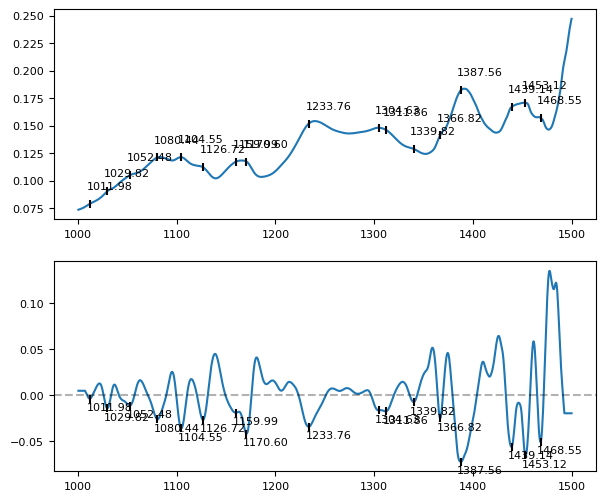

In [19]:
sample = X.mean()
sample = sample[(sample.index >= 1000) & (sample.index <= 1500)]

peaks_second_deriv(sample.index.to_numpy(), 
                   sample.to_numpy(), 
                   window_length=30, 
                   polyorder=2,
                   height=0.001, 
                   prominence=0.00001, 
                   distance=10)

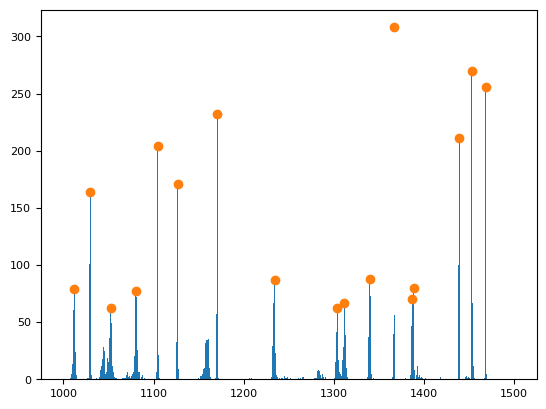

In [20]:
X_1000_1500 = X.iloc[:, (X.columns >= 1000) & (X.columns <= 1500)]

peaks_1000_1500 = find_peaks_matrix(X_1000_1500.columns.to_numpy(), 
                X_1000_1500, 
                window_length=30, 
                height=0.001, 
                prominence=0.0001, 
                distance=7,
                threshold=0.1
                )

<Axes: >

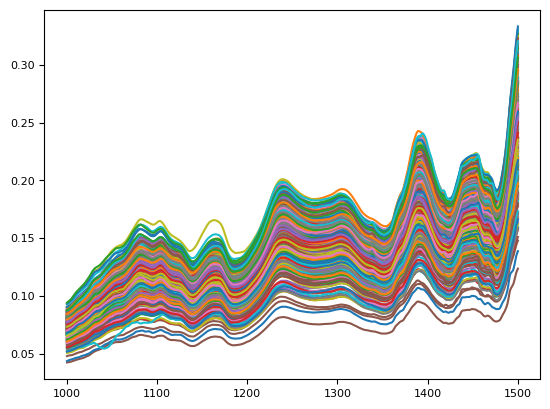

In [13]:
X_1000_1500.T.plot(legend=False)

In [14]:
len(peaks_amides)

22

In [15]:
len(peaks_1000_1500)

22

In [16]:
peaks = np.concatenate([peaks_1000_1500, peaks_amides])

# pd.Series(peaks).to_csv('peaks.csv', index=False)
peaks

array([1011.98 , 1030.3  , 1042.836, 1053.442, 1080.923, 1104.547,
       1127.207, 1160.956, 1171.563, 1234.721, 1303.665, 1312.343,
       1340.789, 1367.305, 1386.59 , 1394.304, 1400.572, 1439.142,
       1454.088, 1469.034, 1491.693, 1493.14 , 1507.604, 1517.246,
       1532.192, 1537.978, 1543.281, 1548.102, 1557.262, 1617.528,
       1624.278, 1628.617, 1631.992, 1636.331, 1644.527, 1651.759,
       1656.58 , 1660.437, 1667.187, 1673.937, 1682.615, 1687.436,
       1694.186, 1698.525])

In [17]:
wavenumber_mask = ((X.columns >= 1000) & (X.columns <= 3700)) & ~((X.columns > 1800) & (X.columns < 2700))
X = X.iloc[:, wavenumber_mask]
X.head(10)

,1000.409,1000.891,1001.373,1001.855,1002.337,1002.819,1003.301,1003.783,1004.266,1004.748,...,3695.485,3695.967,3696.449,3696.931,3697.414,3697.896,3698.378,3698.860,3699.342,3699.824
0,0.063457,0.063555,0.063663,0.063778,0.063901,0.064033,0.064181,0.064354,0.064556,0.064787,...,0.008957,0.008925,0.008899,0.008877,0.008855,0.008833,0.008812,0.008794,0.008780,0.008772
1,0.067789,0.067911,0.068050,0.068202,0.068364,0.068532,0.068706,0.068887,0.069076,0.069272,...,0.009764,0.009773,0.009784,0.009789,0.009783,0.009765,0.009740,0.009716,0.009699,0.009695
2,0.069436,0.069534,0.069629,0.069718,0.069799,0.069877,0.069964,0.070074,0.070226,0.070429,...,0.008203,0.008177,0.008148,0.008115,0.008075,0.008035,0.008001,0.007982,0.007983,0.008004
3,0.074766,0.074961,0.075153,0.075332,0.075489,0.075620,0.075732,0.075839,0.075958,0.076104,...,0.008125,0.008089,0.008047,0.007997,0.007935,0.007865,0.007792,0.007726,0.007676,0.007650
4,0.068835,0.068929,0.069049,0.069194,0.069358,0.069537,0.069723,0.069911,0.070093,0.070267,...,0.010183,0.010167,0.010147,0.010115,0.010069,0.010013,0.009957,0.009913,0.009893,0.009901
5,0.084016,0.084243,0.084490,0.084733,0.084944,0.085107,0.085222,0.085301,0.085370,0.085457,...,0.011001,0.010985,0.010967,0.010941,0.010904,0.010860,0.010813,0.010773,0.010748,0.010741
6,0.086906,0.087019,0.087154,0.087309,0.087481,0.087663,0.087849,0.088032,0.088206,0.088369,...,0.010172,0.010184,0.010192,0.010186,0.010162,0.010123,0.010075,0.010030,0.009998,0.009987
7,0.072981,0.073071,0.073184,0.073319,0.073467,0.073623,0.073788,0.073965,0.074162,0.074383,...,0.010788,0.010788,0.010791,0.010786,0.010765,0.010726,0.010671,0.010607,0.010542,0.010482
8,0.080360,0.080509,0.080682,0.080863,0.081030,0.081166,0.081265,0.081333,0.081385,0.081441,...,0.008408,0.008386,0.008349,0.008290,0.008212,0.008122,0.008034,0.007961,0.007916,0.007906
9,0.080642,0.080723,0.080833,0.080969,0.081130,0.081312,0.081516,0.081743,0.081991,0.082257,...,0.010665,0.010639,0.010600,0.010538,0.010454,0.010360,0.010268,0.010194,0.010152,0.010150


Text(0, 0.5, 'Absorbance')

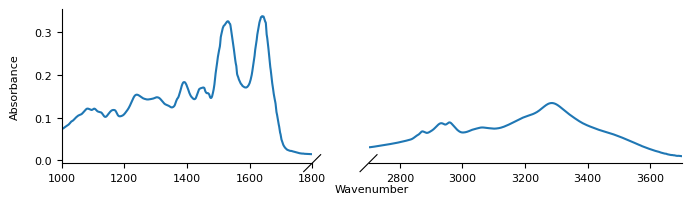

In [18]:
fig = plt.figure(figsize=(8, 2))
bax = brokenaxes(xlims=((1000, 1800), (2700, 3700)))

wn = X.columns
absorbance = X.mean()

bax.plot(wn, absorbance)
# bax.legend(loc=3)
bax.set_xlabel('Wavenumber')
bax.set_ylabel('Absorbance')